## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

import xgboost as xgb
from lazypredict.Supervised import LazyClassifier

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = "images/" f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load Dataset

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

Id          Artist Name       Track Name  Popularity  danceability  energy  \
0   1    Marina Maximilian       Not Afraid       37.00          0.33    0.54   
1   2       The Black Keys  Howlin' for You       67.00          0.72    0.75   
2   3  Royal & the Serpent          phuck u         NaN          0.58    0.80   
3   4   Detroit Blues Band      Missing You       12.00          0.52    0.31   
4   5         Coast Contra          My Lady       48.00          0.56    0.78   

    key  loudness  mode  speechiness  acousticness  instrumentalness  \
0  9.00     -6.65     0         0.04          0.38               NaN   
1 11.00     -5.54     1         0.09          0.03              0.05   
2  7.00     -6.09     1         0.06          0.00              0.64   
3   NaN    -14.71     1         0.03          0.91              0.02   
4  6.00     -5.10     0         0.25          0.18               NaN   

   liveness  valence  tempo  duration_in min/ms  time_signature  Class  
0      0.11     0.23 152.43           204947.00               4      9  
1      0.10     0.38 132.92           191956.00               4      6  
2      0.28     0.64 159.95           161037.00               4     10  
3      0.30     0.50 172.47           298093.00               3      2  
4      0.21     0.62  88.31           254145.00               4      5

## EDA

In [5]:
def wrangle(df):
    # List of columns that will be dropped
    drop_cols = []
    
    # Transforming all ms rows to min 
    df.loc[df['duration_in min/ms'] > 5000 ,'duration_in min/ms'] = df.loc[df['duration_in min/ms'] > 5000 ,
                                                                           'duration_in min/ms']/60000
    df.rename(columns={"duration_in min/ms": "duration_in min"}, inplace=True)
    
    # Handle null values
    mean_cols = ["Popularity"]
    median_cols = ["instrumentalness"]
    mode_cols = ["key"]

    mean_imputer = SimpleImputer(strategy="mean")
    median_imputer = SimpleImputer(strategy="median")
    mode_imputer = SimpleImputer(strategy="most_frequent")

    df[mean_cols] = mean_imputer.fit_transform(df[mean_cols])
    df[median_cols] = median_imputer.fit_transform(df[median_cols])
    df[mode_cols] = mode_imputer.fit_transform(df[mode_cols])
    
    # Add high cardinality columns to the list
    drop_cols.append("Artist Name")
    drop_cols.append("Track Name")
    
    # Change key column data type from float to int
    df["key"] = df["key"].astype(int)
    
    # Transform feature from others
    df["tempo_loudness"] = df["tempo"] * df["loudness"]
    
    # Applying transformations on the features
    df['liveness']=np.log(df['liveness'])
    df['duration_in min']=np.sqrt(df['duration_in min'])
    df['loudness']=np.cbrt(df['loudness'])
    df['tempo_loudness']=np.cbrt(df['tempo_loudness'])
    df['speechiness']=np.reciprocal(df['speechiness'])
    df['acousticness']=np.cbrt(df['acousticness'])
    df['instrumentalness']=np.log(df['instrumentalness'])
    
    # Scale data
    columns = df.select_dtypes("float").columns
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    
    # Add ID column to drop list
    drop_cols.append("Id")
    
    # Add non-corr features that will be dropped
    drop_cols.append("loudness")
    drop_cols.append('liveness')
    drop_cols.append("key")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  14396 non-null  int64  
 1   Artist Name         14396 non-null  object 
 2   Track Name          14396 non-null  object 
 3   Popularity          14063 non-null  float64
 4   danceability        14396 non-null  float64
 5   energy              14396 non-null  float64
 6   key                 12787 non-null  float64
 7   loudness            14396 non-null  float64
 8   mode                14396 non-null  int64  
 9   speechiness         14396 non-null  float64
 10  acousticness        14396 non-null  float64
 11  instrumentalness    10855 non-null  float64
 12  liveness            14396 non-null  float64
 13  valence             14396 non-null  float64
 14  tempo               14396 non-null  float64
 15  duration_in min/ms  14396 non-null  float64
 16  time

In [7]:
train.describe().T

count      mean       std    min       25%       50%  \
Id                 14396.00   7198.50   4155.91   1.00   3599.75   7198.50   
Popularity         14063.00     44.53     17.42   1.00     33.00     44.00   
danceability       14396.00      0.54      0.17   0.06      0.43      0.55   
energy             14396.00      0.66      0.24   0.00      0.51      0.70   
key                12787.00      5.95      3.20   1.00      3.00      6.00   
loudness           14396.00     -7.90      4.06 -39.95     -9.54     -7.01   
mode               14396.00      0.64      0.48   0.00      0.00      1.00   
speechiness        14396.00      0.08      0.09   0.02      0.03      0.05   
acousticness       14396.00      0.25      0.31   0.00      0.00      0.08   
instrumentalness   10855.00      0.18      0.30   0.00      0.00      0.00   
liveness           14396.00      0.20      0.16   0.01      0.10      0.13   
valence            14396.00      0.49      0.24   0.02      0.30      0.48   
tempo              14396.00    122.70     29.54  30.56     99.80    120.06   
duration_in min/ms 14396.00 200094.22 111689.10   0.50 165445.75 208941.00   
time_signature     14396.00      3.92      0.36   1.00      4.00      4.00   
Class              14396.00      6.70      3.21   0.00      5.00      8.00   

                         75%        max  
Id                  10797.25   14396.00  
Popularity             56.00     100.00  
danceability            0.66       0.99  
energy                  0.86       1.00  
key                     9.00      11.00  
loudness               -5.16       1.34  
mode                    1.00       1.00  
speechiness             0.08       0.95  
acousticness            0.43       1.00  
instrumentalness        0.20       1.00  
liveness                0.26       0.99  
valence                 0.67       0.99  
tempo                 141.99     217.42  
duration_in min/ms 252247.00 1477187.00  
time_signature          4.00       5.00  
Class                  10.00      10.00

Column duration has two data units 'ms' and 'min' we should transfrom it all to one unit

In [8]:
train.loc[train['duration_in min/ms'] > 5000 ,'duration_in min/ms'] = train.loc[train['duration_in min/ms'] > 5000 ,'duration_in min/ms']/60000
train.rename(columns={"duration_in min/ms": "duration_in min"}, inplace=True)

In [9]:
train.head()

Id          Artist Name       Track Name  Popularity  danceability  energy  \
0   1    Marina Maximilian       Not Afraid       37.00          0.33    0.54   
1   2       The Black Keys  Howlin' for You       67.00          0.72    0.75   
2   3  Royal & the Serpent          phuck u         NaN          0.58    0.80   
3   4   Detroit Blues Band      Missing You       12.00          0.52    0.31   
4   5         Coast Contra          My Lady       48.00          0.56    0.78   

    key  loudness  mode  speechiness  acousticness  instrumentalness  \
0  9.00     -6.65     0         0.04          0.38               NaN   
1 11.00     -5.54     1         0.09          0.03              0.05   
2  7.00     -6.09     1         0.06          0.00              0.64   
3   NaN    -14.71     1         0.03          0.91              0.02   
4  6.00     -5.10     0         0.25          0.18               NaN   

   liveness  valence  tempo  duration_in min  time_signature  Class  
0      0.11     0.23 152.43             3.42               4      9  
1      0.10     0.38 132.92             3.20               4      6  
2      0.28     0.64 159.95             2.68               4     10  
3      0.30     0.50 172.47             4.97               3      2  
4      0.21     0.62  88.31             4.24               4      5

In [10]:
train.isna().any()

Id                  False
Artist Name         False
Track Name          False
Popularity           True
danceability        False
energy              False
key                  True
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness     True
liveness            False
valence             False
tempo               False
duration_in min     False
time_signature      False
Class               False
dtype: bool

There is null values we need to handle it

In [11]:
mean_cols = ["Popularity"]
median_cols = ["instrumentalness"]
mode_cols = ["key"]

mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")
mode_imputer = SimpleImputer(strategy="most_frequent")

train[mean_cols] = mean_imputer.fit_transform(train[mean_cols])
train[median_cols] = median_imputer.fit_transform(train[median_cols])
train[mode_cols] = mode_imputer.fit_transform(train[mode_cols])

In [12]:
train["Artist Name"].value_counts()

Backstreet Boys    58
Westlife           53
Britney Spears     47
Omer Adam          39
Eyal Golan         38
                   ..
Snowy Dunes         1
WhoMadeWho          1
Tom Lewis Band      1
Dozer               1
Freddy Fender       1
Name: Artist Name, Length: 7913, dtype: int64

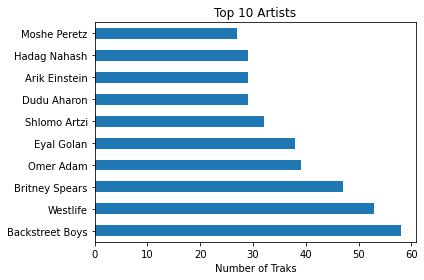

In [13]:
train["Artist Name"].value_counts(sort=True).head(10).plot(kind="barh")
plt.xlabel("Number of Traks")
plt.title("Top 10 Artists")
save_fig("Top 10 Artist")
plt.show()

In [14]:
train["Track Name"].value_counts()

Fire                              8
Ghost                             7
Runaway                           7
Forever                           6
Dreams                            6
                                 ..
Tangerine                         1
Three Alley Cats                  1
◊™◊ë◊ï◊ê◊ô ◊î◊ô◊ï◊ù               1
In My Room                        1
Before the Next Teardrop Falls    1
Name: Track Name, Length: 12455, dtype: int64

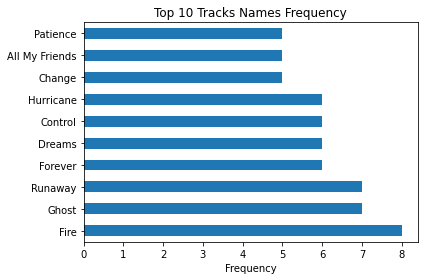

In [15]:
train["Track Name"].value_counts(sort=True).head(10).plot(kind="barh")
plt.xlabel("Frequency")
plt.title("Top 10 Tracks Names Frequency")
save_fig("Top 10 Tracks Names Frequency")
plt.show()

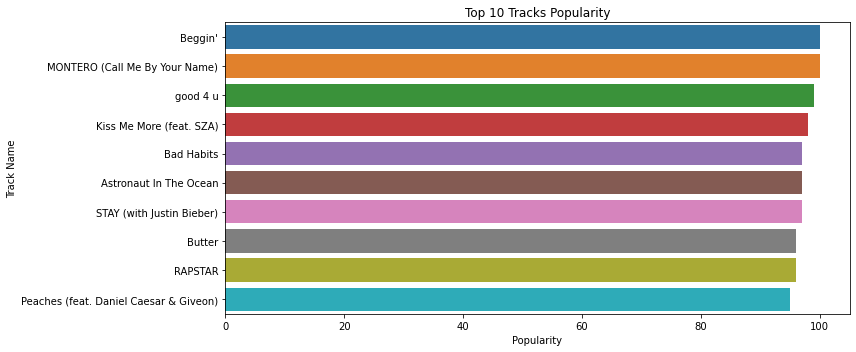

In [16]:
popularity_train = train.nlargest(10, 'Popularity')[["Track Name", "Popularity"]]
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=popularity_train, x="Popularity", y="Track Name", ax=ax)
plt.title("Top 10 Tracks Popularity")
save_fig("Top 10 Tracks Popularity")
plt.show()


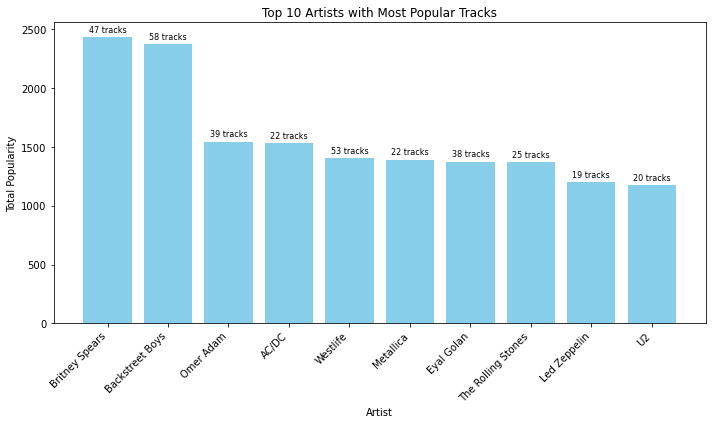

In [17]:
grouped_data = train.groupby("Artist Name")['Popularity'].agg(['sum', 'count']).reset_index()
top_10_artists = grouped_data.nlargest(10, 'sum')

artist_names = top_10_artists['Artist Name']
popularity_scores = top_10_artists['sum']
num_tracks = top_10_artists['count']

plt.figure(figsize=(10, 6))
bars = plt.bar(artist_names, popularity_scores, color='skyblue')

plt.xlabel('Artist')
plt.ylabel('Total Popularity')
plt.title('Top 10 Artists with Most Popular Tracks')
plt.xticks(rotation=45, ha='right')

for bar, num_tracks in zip(bars, num_tracks):
    plt.annotate(f'{num_tracks} tracks', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout() 
save_fig("Top 10 Artists with Most Popular Tracks")
plt.show()


There is columns that have high cardinallity in our features we should drop them!

In [18]:
high_cardinality_cols = ["Artist Name", "Track Name"]
train.drop(columns=high_cardinality_cols, inplace=True)

In [19]:
train["key"].value_counts()

7.00     3259
9.00     1590
2.00     1582
1.00     1351
4.00     1252
11.00    1176
5.00     1115
6.00      963
8.00      872
10.00     825
3.00      411
Name: key, dtype: int64

column 'key' should be type int not folat

In [20]:
train["key"] = train["key"].astype(int)

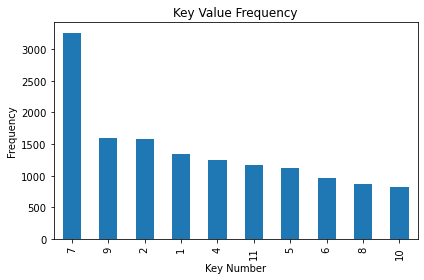

In [21]:
train["key"].value_counts(sort=True).head(10).plot(kind="bar")
plt.xlabel("Key Number")
plt.ylabel("Frequency")
plt.title("Key Value Frequency")
save_fig("Key Value Frequency")
plt.show()

In [22]:
train["mode"].value_counts()

1    9217
0    5179
Name: mode, dtype: int64

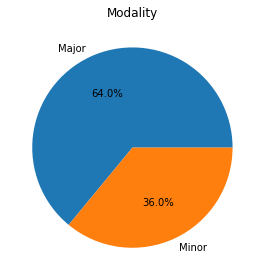

In [23]:
plt.pie(train["mode"].value_counts(), labels=["Major", "Minor"], autopct='%1.1f%%')
plt.title("Modality")
save_fig("Key Value Frequency")
plt.show()

In [24]:
train["time_signature"].value_counts()

4    13149
3      994
5      166
1       87
Name: time_signature, dtype: int64

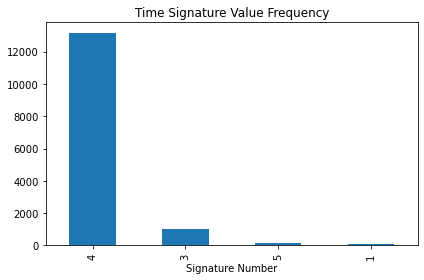

In [25]:
train["time_signature"].value_counts(sort=True).head(10).plot(kind="bar")
plt.xlabel("Signature Number")
plt.title("Time Signature Value Frequency")
save_fig("Time Signature Value Frequency")
plt.show()

That's correct 4/4 time is also known as “common time” because it is the most common time we use in Western music.

In [26]:
train["Class"].value_counts()

10    3959
6     2069
9     2019
8     1483
5     1157
1     1098
2     1018
0      500
7      461
3      322
4      310
Name: Class, dtype: int64

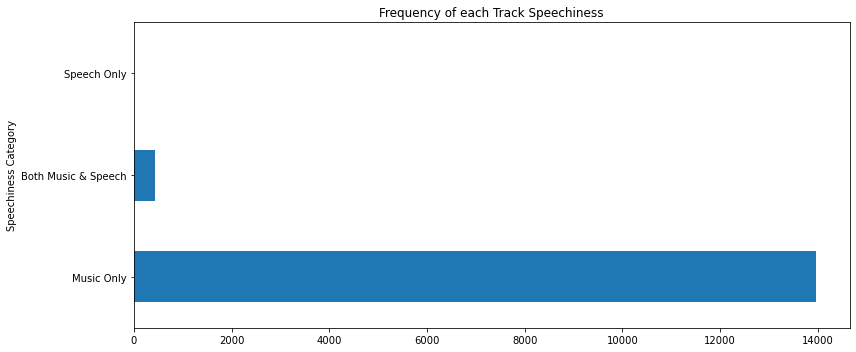

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.cut(train["speechiness"],
       bins=[0., 0.33, 0.66, 1],
       labels=["Music Only", "Both Music & Speech", "Speech Only"]).value_counts().plot(
                                                            kind="barh",
                                                            xlabel="Speechiness Category",
                                                            ylabel="Frequency",
                                                            title="Frequency of each Track Speechiness",
                                                            ax=ax
                                                        )
save_fig("Frequency of each Track Speechiness")
plt.show()

Labels
- [0 - 0.33]    -> contain music and other non-speech-like tracks
- [0.33 - 0.66] -> contain both music and speech
- [0.66 - 1]    -> contain entirely of spoken words

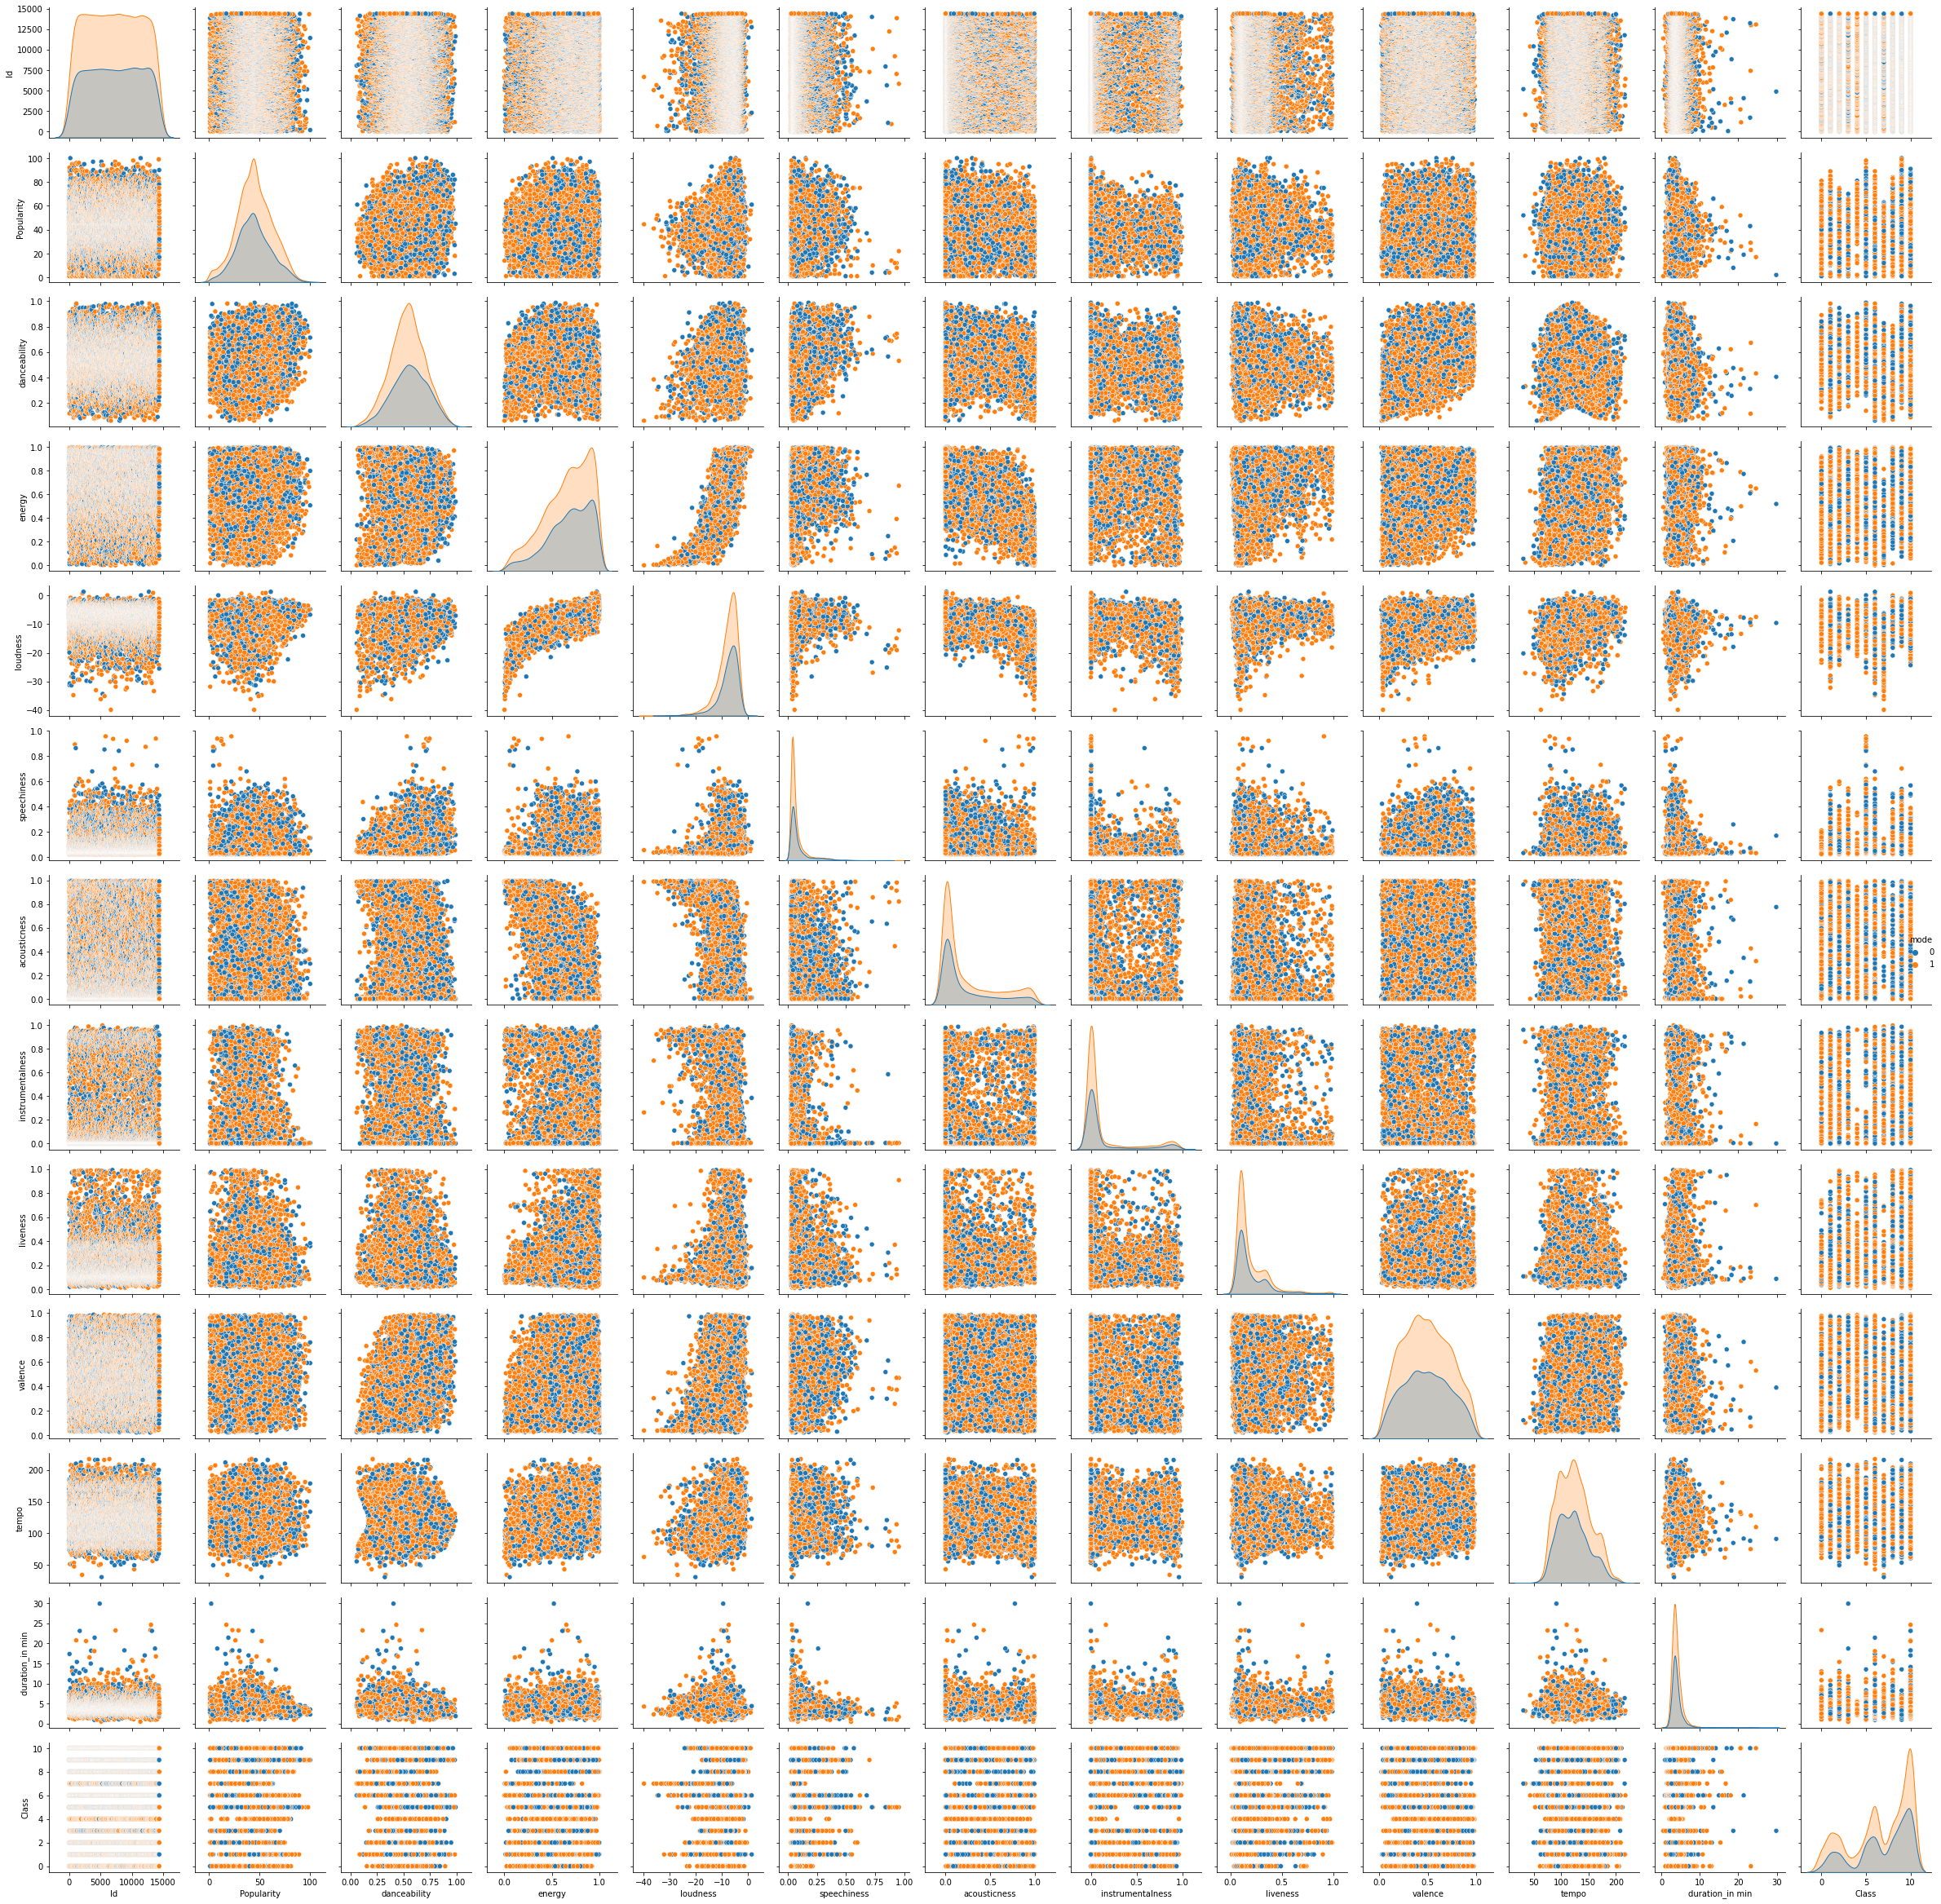

In [28]:
sns.pairplot(train.drop(["key", "time_signature"], axis=1), hue="mode")
save_fig("Pairplot")
plt.show()

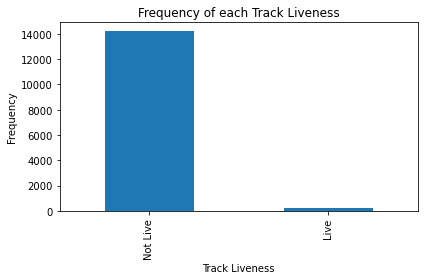

In [29]:
pd.cut(train["liveness"],
       bins=[0., 0.8, 1],
       labels=["Not Live", "Live"]).value_counts().plot(
                                                            kind="bar",
                                                            xlabel="Track Liveness",
                                                            ylabel="Frequency",
                                                            title="Frequency of each Track Liveness"
                                                        )
save_fig("Frequency of each Track Liveness")
plt.show()

Labels
- [0 - 0.8] -> Low liveness means track isn't live
- [0.8 - 1] -> High liveness means track is live

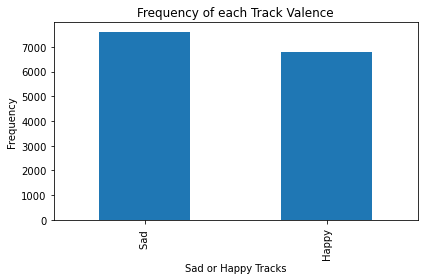

In [30]:
pd.cut(train["valence"],
       bins=[0., 0.5, 1],
       labels=["Sad ", "Happy"]).value_counts().plot(
                                                            kind="bar",
                                                            xlabel="Sad or Happy Tracks",
                                                            ylabel="Frequency",
                                                            title="Frequency of each Track Valence"
                                                        )

save_fig("Frequency of each Track Valence")
plt.show()


Labels
- [0 - 0.5] -> Sad, Depressed and Angry
- [0.5 - 1] -> Happy and Cheerful

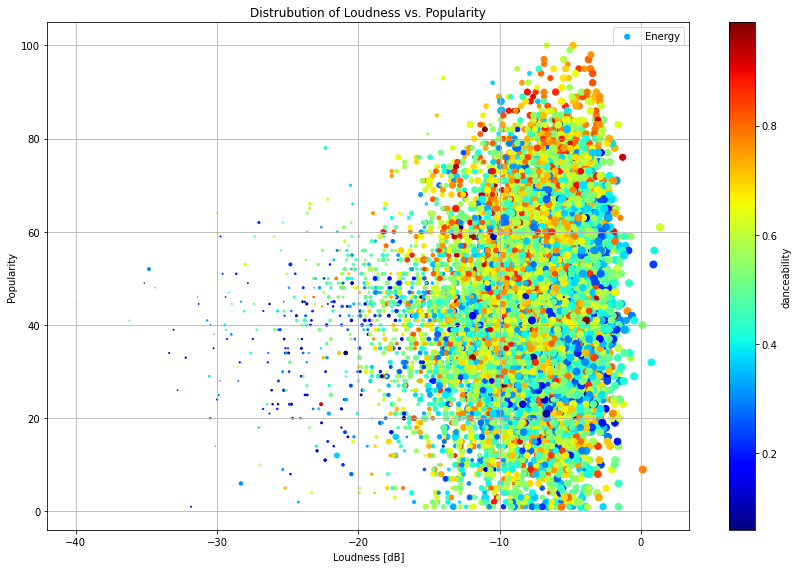

In [31]:
train.plot(kind="scatter", x="loudness", y="Popularity", grid=True,
             s=train["energy"] * 50, label="Energy",
             c="danceability", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(12, 8))
plt.xlabel("Loudness [dB]")
plt.ylabel("Popularity")
plt.title("Distrubution of Loudness vs. Popularity")
save_fig("Distrubution of Loudness vs. Popularity")
plt.show()

Adding a new feature

In [32]:
train["tempo_loudness"] = train["tempo"] * train["loudness"]

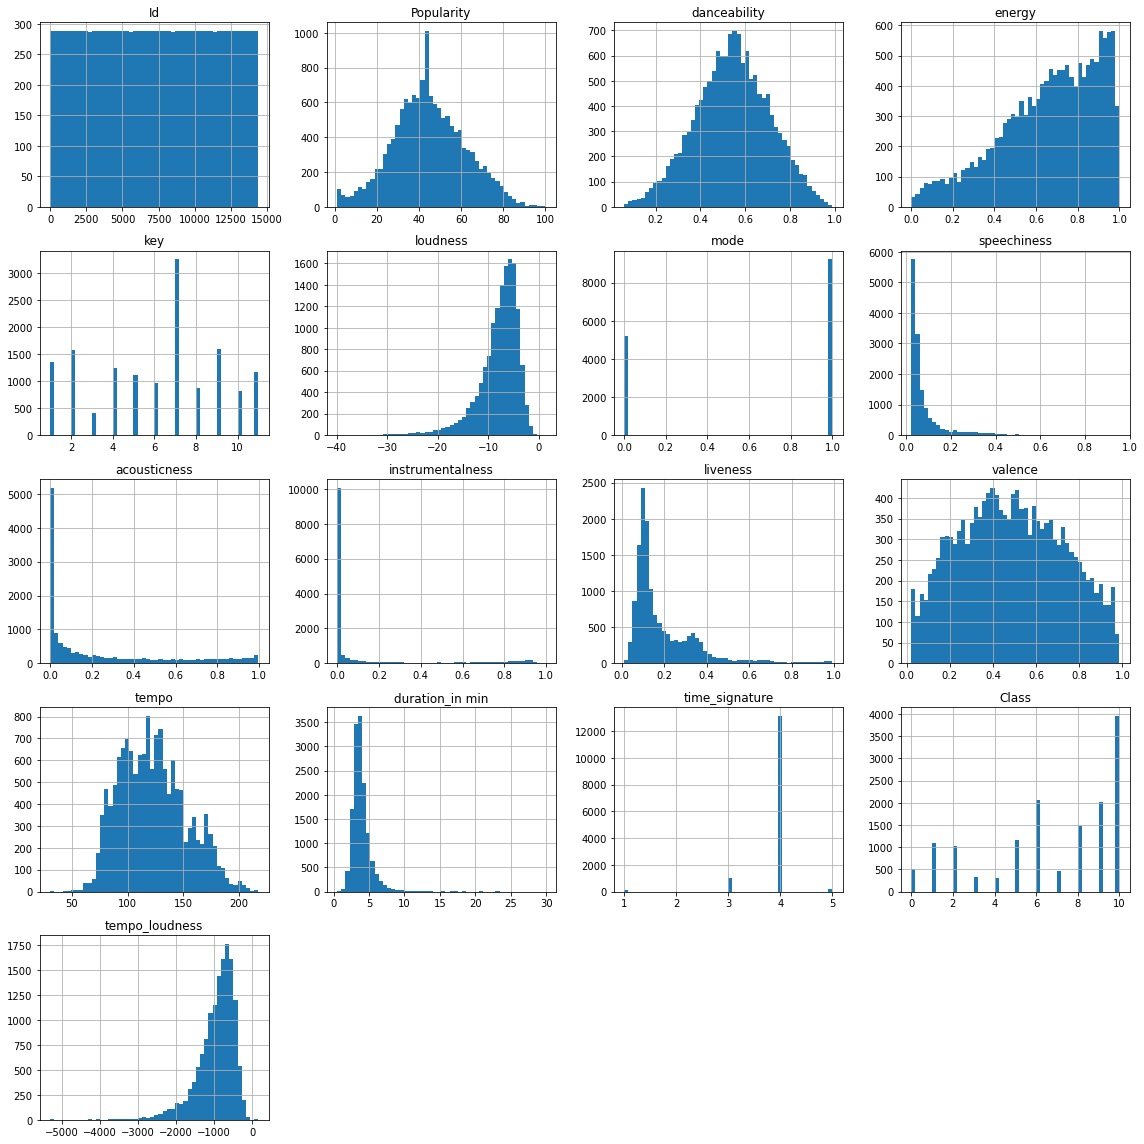

In [33]:
train.hist(bins=50, figsize=(16, 16))
save_fig("Data Histogram Befor Transformation")
plt.show()

Applying some transformations on the features

In [34]:
train['liveness']=np.log(train['liveness'])
train['duration_in min']=np.sqrt(train['duration_in min'])
train['loudness']=np.cbrt(train['loudness'])
train['tempo_loudness']=np.cbrt(train['tempo_loudness'])
train['speechiness']=np.reciprocal(train['speechiness'])
train['acousticness']=np.cbrt(train['acousticness'])
train['instrumentalness']=np.log(train['instrumentalness'])

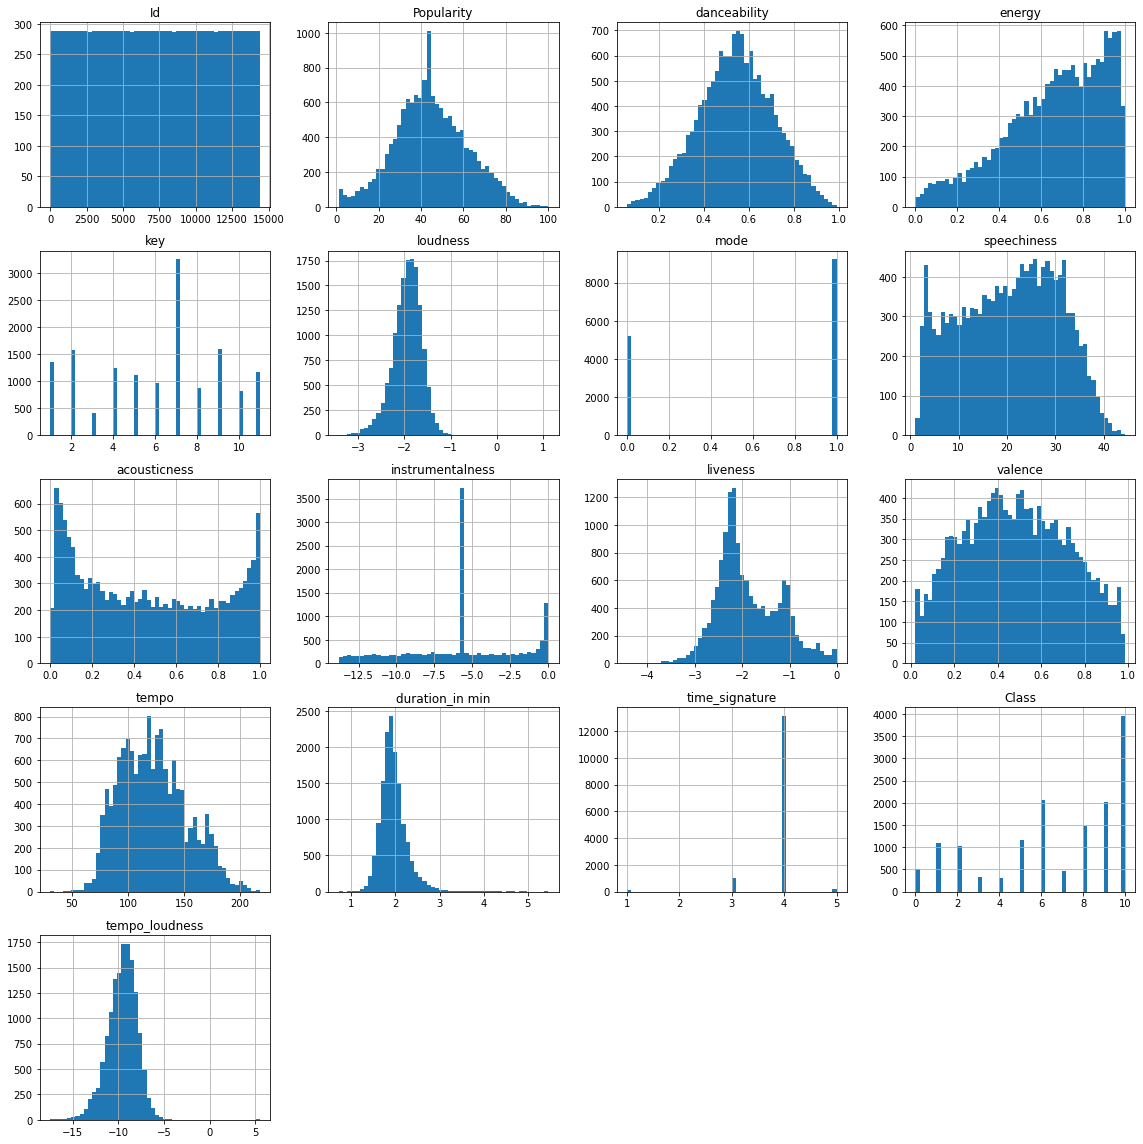

In [35]:
train.hist(bins=50, figsize=(16, 16))
save_fig("Data Histogram After Transformation")
plt.show()

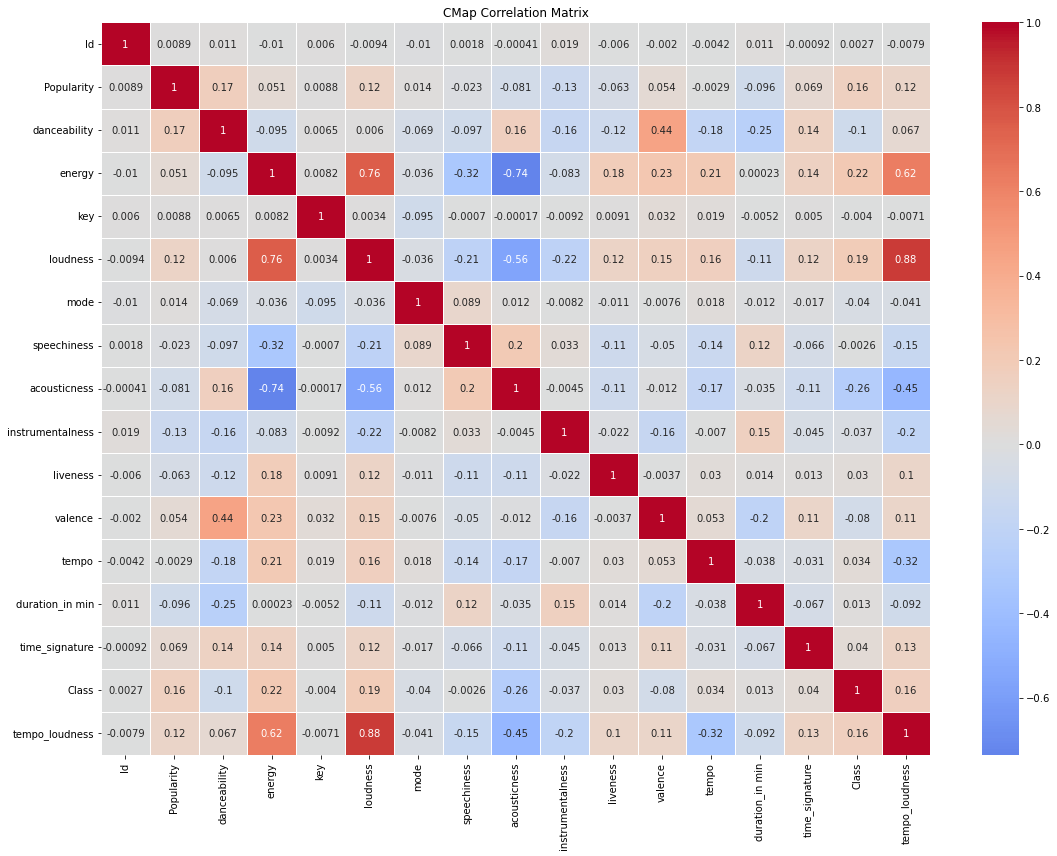

In [36]:
plt.figure(figsize=(16, 12))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('CMap Correlation Matrix')
save_fig("CMap Correlation Matrix")
plt.show()

In [37]:
non_corr_cols = ["Id", "liveness", "loudness", "key"]
train.drop(columns=non_corr_cols, inplace=True)

We need to delete high correlated features except the target feature 'class'
- loudness

In [38]:
train.columns

Index(['Popularity', 'danceability', 'energy', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'valence', 'tempo',
       'duration_in min', 'time_signature', 'Class', 'tempo_loudness'],
      dtype='object')

In [39]:
columns = train.select_dtypes("float").columns

scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])

In [40]:
stratify_column = 'time_signature'
strat_train_set, strat_test_set = train_test_split(train, test_size=0.2, stratify=train[stratify_column], random_state=42)

In [41]:
strat_test_set[stratify_column].value_counts() / len(strat_test_set)

4   0.91
3   0.07
5   0.01
1   0.01
Name: time_signature, dtype: float64

In [42]:
def income_cat_proportions(data):
    return data[stratify_column].value_counts() / len(data)

train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(train),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = stratify_column
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

Overall %  Stratified %  Random %  Strat. Error %  \
time_signature                                                      
1                    0.60          0.59      0.56           -2.33   
3                    6.90          6.91      6.53            0.07   
4                   91.34         91.35     91.60            0.02   
5                    1.15          1.15      1.32           -0.63   

                Rand. Error %  
time_signature                 
1                       -8.07  
3                       -5.46  
4                        0.28  
5                       14.43

In [43]:
X_train = strat_train_set.drop('Class', axis=1)
y_train = strat_train_set['Class']
X_test = strat_test_set.drop('Class', axis=1)
y_test = strat_test_set['Class']

In [44]:
# X_train, X_test, y_train, y_test = train_test_split(train.drop("Class", axis=1), train["Class"], test_size=0.2, random_state=42)

In [45]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:18<00:00,  2.69s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.35               0.46    None      0.33   
QuadraticDiscriminantAnalysis      0.46               0.45    None      0.43   
GaussianNB                         0.41               0.44    None      0.38   
XGBClassifier                      0.47               0.43    None      0.46   
LGBMClassifier                     0.48               0.43    None      0.47   
SVC                                0.50               0.42    None      0.46   
ExtraTreesClassifier               0.46               0.41    None      0.44   
RandomForestClassifier             0.46               0.41    None      0.45   
BaggingClassifier                  0.42               0.40    None      0.42   
LogisticRegression                 0.46               0.39    None      0.42   
LinearDiscriminantAnalysis         0.44 

In [46]:
svc_model = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_svc_model = grid_search.best_estimator_

y_pred = best_svc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

KeyboardInterrupt: 

In [50]:
model = SVC(C=10)

In [51]:
model.fit(X_train, y_train)

SVC(C=10)

In [52]:
y_pred = model.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred)

0.5038194444444445

In [63]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 12,
    'eval_metric': 'mlogloss',
    'max_depth': 3,
    'eta': 0.15
}

num_rounds = 50
xgboost_model = xgb.train(params, dtrain, num_rounds)

y_predXGB = xgboost_model.predict(dtest)
y_pred_binary = [round(pred) for pred in y_predXGB]

accuracy = accuracy_score(y_test, y_pred_binary)
print(accuracy)


0.5114583333333333


In [54]:
samples = pd.read_csv('sample_submission.csv')
samples.head()

Id  Class
0  14397      6
1  14398      6
2  14399      9
3  14400     10
4  14401      5

In [55]:
test = wrangle(test)

In [65]:
xgbtest = xgb.DMatrix(test)

In [66]:
y_sub_pred = xgboost_model.predict(xgbtest)

In [67]:
accuracy_score(samples["Class"], y_sub_pred)

0.7816666666666666

In [68]:
samples["Class"] = y_sub_pred

In [69]:
samples.to_csv("submission.csv", index=None)